# Load Data

In [1]:
from pathlib import Path

while Path.cwd().name != 'language-model-toxicity':
    %cd ..

%matplotlib inline  

/Users/suching/Github/language-model-toxicity


In [2]:
import pandas as pd
import seaborn as sns
sns.set(context="paper", style="white", font_scale=1.5, palette="RdBu") 
from tqdm.notebook import trange, tqdm
from spacy.tokenizer import Tokenizer
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas("progress")
from nltk.stem.porter import *
import spacy

In [3]:
def read_data(dir_):
    total = len([x for x in Path().iterdir()])
    rows = [[str(file), file.read_text()] for file in tqdm(Path("data/subsample_100k/corpus").iterdir(), total=total)]
    return pd.DataFrame(rows, columns=['filename', 'text'])

In [4]:
files = pd.read_json("data/subsample_100k_ner_tokenized.jsonl", lines=True)

In [5]:
df = pd.read_csv("data/subsample_100k/docs.csv")

In [6]:
files['filename'] = files['filename'].str.split('/').apply(lambda x: x[-1])

In [7]:
master = df.merge(files)

In [8]:
master['avg_toxicity'] = master.insult + master.severe_toxicity + master.toxicity + master.profanity + master.sexually_explicit + master.flirtation + master.identity_attack + master.threat
master['avg_toxicity'] = master['avg_toxicity'] / 8
master['tokenized_text'] = master['text'].str.split()

In [9]:
master.columns = ['filename', 'Insult Score', 'Severe Toxicity Score', 'Toxicity Score', 'Profanity Score', 'Sexually Explicit Score', 'Flirtation Score', 'Identity Attack Score', 'Threat Score', 'entities_NORP', 'entities_PERSON', 'text', 'Average Toxicity Score']

### Load URLs

In [45]:
urls = pd.read_csv("data/openwebtext-urls.csv")
site_bias = pd.read_csv("data/mbfc.csv")
site_bias.columns=['source_url', 'domain', 'url', 'fact', 'bias']
urls = urls.merge(site_bias, on='domain',how='left')

# Analysis

## Toxicity Distributions

In [32]:
def plot_distributions(df, compare_df=None, kde=False, logy=False):
    f, axes = plt.subplots(4, 2, figsize=(10, 10))
    placement = [["Insult Score", "Severe Toxicity Score"],
                 ["Toxicity Score", "Profanity Score"],
                 ["Sexually Explicit Score", "Flirtation Score"],
                 ["Identity Attack Score", "Threat Score"]]
    for ix, row in enumerate(placement):
        for jx, col in enumerate(row):
            sns.distplot(df[col], kde=kde, bins=50, ax=axes[ix, jx])
            if compare_df is not None:
                sns.distplot(compare_df[col], kde=kde, bins=50, ax=axes[ix, jx], color="blue")
            if (ix, jx) == (0, 0):
                axes[ix, jx].set_ylabel("Density")
            axes[ix, jx].set_xlim([0, 1])
            if logy:
                axes[ix, jx].set_yscale('log')
                
    plt.tight_layout()

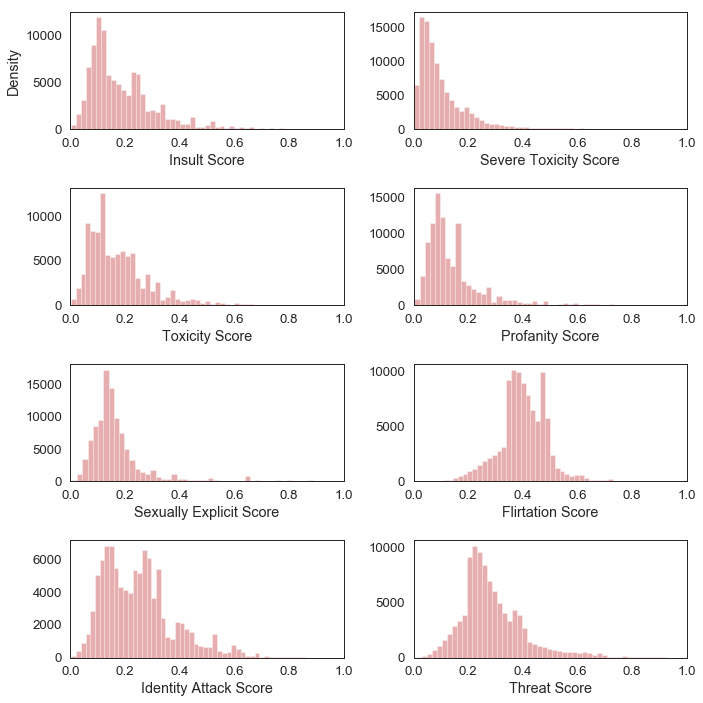

In [19]:
plot_distributions(master)

(0, 1)

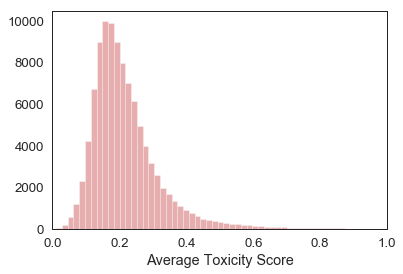

In [20]:
ax = sns.distplot(master['Average Toxicity Score'], kde=False, bins=50)
ax.set_xlim([0, 1])

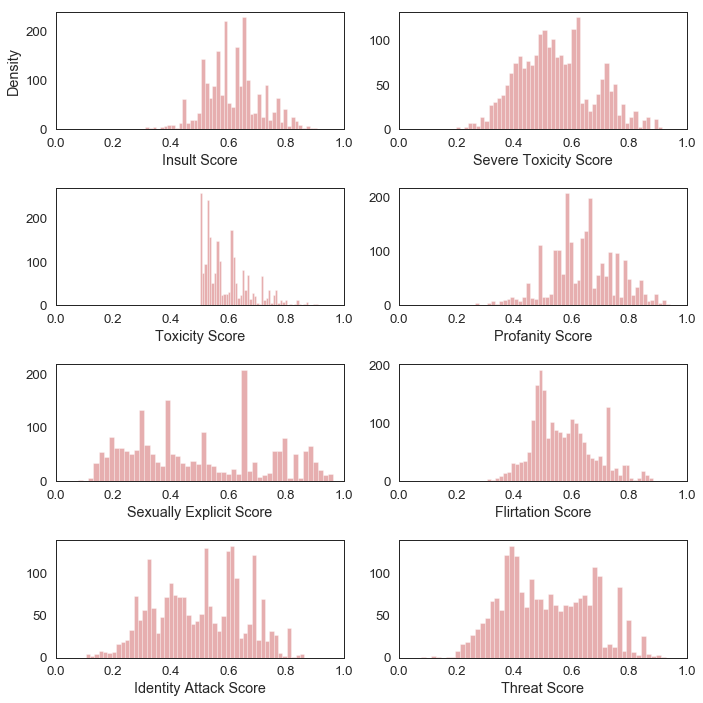

In [23]:
plot_distributions(master.loc[(master['Toxicity Score'] > 0.5)])

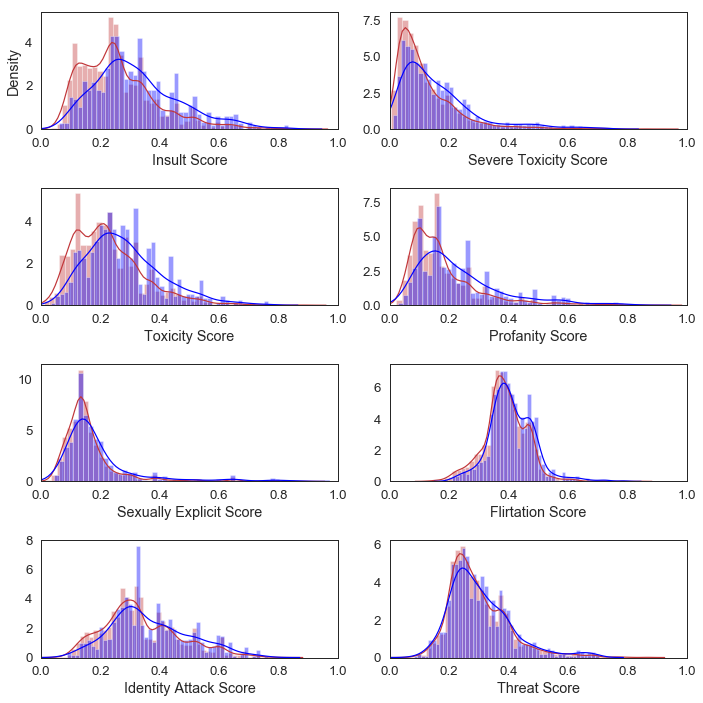

In [41]:
plot_distributions(master.loc[master['entities_PERSON'].apply(lambda x: 'Trump' in x)],
                   compare_df=master.loc[master['entities_PERSON'].apply(lambda x: 'Hillary' in x)],
                   kde=True,
                   logy=False)

## Naughty Words

In [43]:
with open('data/naughty_words.txt', 'r') as f:
    naughty_words = [x.strip() for x in f.readlines()]
    
def get_naughty_words(text):
    if len(set(text.split()) & set(naughty_words)) > 0:
        return set(text.split()) & set(naughty_words)
    else:
        return np.nan

master['naughty_words'] = master.text.progress_apply(get_naughty_words)
master['is_toxic_naughty_words'] = ~master.naughty_words.isna()

### Most common naughty words

In [13]:
pd.Series([item for row in master['naughty_words'].dropna() for item in row]).value_counts().head(n=15)

sex         2582
rape        1031
shit         781
fucking      620
dick         606
fuck         518
ass          490
hardcore     406
sexy         341
suck         318
porn         316
butt         290
nude         234
raping       220
bullshit     204
dtype: int64

### Naughty word false positives

In [14]:
fp = master.loc[(master['is_toxic_naughty_words'] == 1) & (master['Toxicity Score'] < 0.5)]
pd.Series([item for row in fp['naughty_words'] for item in row]).value_counts().head(n=15)

sex           2249
rape           874
dick           529
shit           406
hardcore       384
ass            295
sexy           294
porn           245
suck           244
butt           243
fucking        238
nude           202
escort         192
domination     188
raping         184
dtype: int64

### Naughty words vs. Perspective API

In [17]:
from sklearn.metrics import precision_recall_fscore_support
score_cols = [col for col in master.columns if "Score" in col]
precs = []
recalls = []
f1s = []
for col in score_cols:
    precision, recall, f1, _ = precision_recall_fscore_support(y_pred=master['is_toxic_naughty_words'],
                                                              y_true=master[col] > 0.5,
                                                              average='binary')
    print(f"{col.upper()}: precision: {precision}, recall: {recall}, f1: {f1}")
    precs.append(precision)
    recalls.append(recall)
    f1s.append(f1)

INSULT SCORE: precision: 0.20182291666666666, recall: 0.5535714285714286, f1: 0.2958015267175573
SEVERE TOXICITY SCORE: precision: 0.11675347222222222, recall: 0.766928011404134, f1: 0.2026556172897636
TOXICITY SCORE: precision: 0.1591796875, recall: 0.6626016260162602, f1: 0.2566929133858268
PROFANITY SCORE: precision: 0.19173177083333334, recall: 0.690504103165299, f1: 0.30012738853503185
SEXUALLY EXPLICIT SCORE: precision: 0.2684461805555556, recall: 0.7844007609384908, f1: 0.39999999999999997
FLIRTATION SCORE: precision: 0.2965494791666667, recall: 0.34230961923847697, f1: 0.31779069767441864
IDENTITY ATTACK SCORE: precision: 0.1929253472222222, recall: 0.3185808994803799, f1: 0.24031898357775222
THREAT SCORE: precision: 0.1557074652777778, recall: 0.26200474712433813, f1: 0.19533111005240592
AVERAGE TOXICITY SCORE: precision: 0.15201822916666666, recall: 0.7428419936373277, f1: 0.25238695730499006


## Targeted Groups

In [21]:
def extract_entity(doc, label):
    norps = []
    for ent in doc.ents:
        if ent.label_ == label: 
            norps.append(ent.text)
    return norps

def get_popular_entities(df, entity, entity_label, remove=[], convert={}):
    stemmer = PorterStemmer()
    entities = [stemmer.stem(st.lower()) for row in tqdm(df[entity]) for st in row]
    entities = [x for x in entities if x not in remove]
    if convert:
        entities = [convert[x] if convert.get(x) else x for x in entities]
    ax = pd.Series(entities).value_counts().head(n=10).plot(kind='barh')
    ax.set_ylabel(entity_label)
    ax.set_xlabel("Number of Documents")
    plt.tight_layout()

In [22]:
def extract_pos(doc, label):
    norps = []
    for token in doc:
        if token.tag_ == label: 
            norps.append(token.text)
    return norps

def get_popular_pos(df, pos):
    df[pos] = df.nlp_docs.progress_apply(lambda x: extract_pos(x, pos))
    stemmer = PorterStemmer()
    pos_ = [stemmer.stem(st.lower()) for row in tqdm(df[pos]) for st in row]
    ax = pd.Series(pos_).value_counts().head(n=15).plot(kind='barh')
    ax.set_ylabel(pos)
    ax.set_xlabel("Number of Docs")

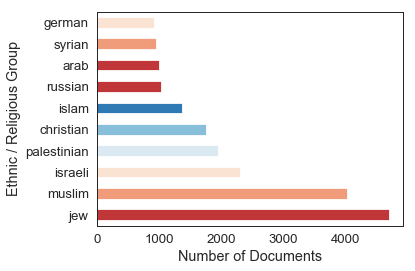

In [24]:
subdf = master.loc[(master['Identity Attack Score'] > 0.5)]
get_popular_entities(subdf,
                     "entities_NORP",
                     "Ethnic / Religious Group",
                     remove=["american", "republican", "democrat"],
                     convert={"jewish": "jew", "isra": "israeli"})
plt.savefig("ethnic_religious_groups.pdf", dpi=300)

## URL Domains Analysis

### Most popular domains

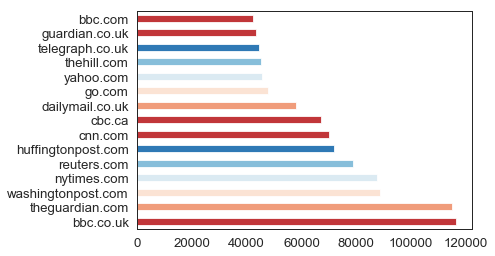

In [46]:
urls.domain.value_counts().head(n=15).plot(kind='barh')

### Biased News Analysis

In [47]:
urls.bias.value_counts() / urls.shape[0]

left-center      0.072355
left             0.044979
right            0.031731
center           0.029599
right-center     0.015717
extreme-right    0.005299
extreme-left     0.000138
Name: bias, dtype: float64

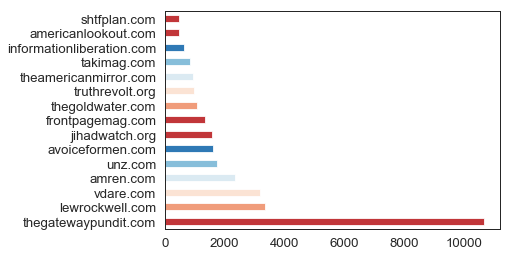

In [52]:
ax = urls.loc[urls['bias'] == 'extreme-right'].domain.value_counts().head(n=15).plot(kind='barh')

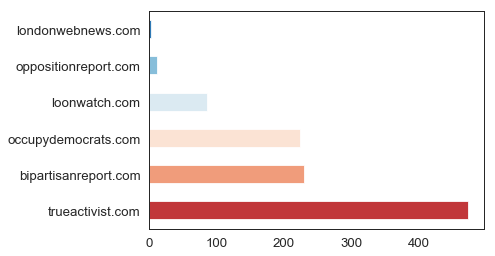

In [53]:
ax = urls.loc[urls['bias'] == 'extreme-left'].domain.value_counts().head(n=15).plot(kind='barh')

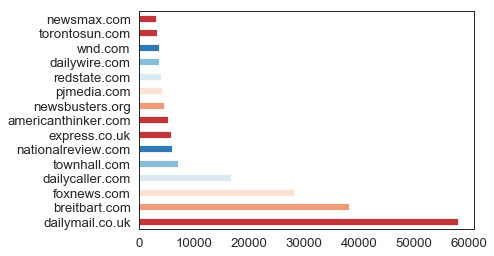

In [59]:
ax = urls.loc[urls['bias'] == 'right'].domain.value_counts().head(n=15).plot(kind='barh')

### Fake News Analysis

In [60]:
urls.fact.value_counts() / urls.shape[0]

HIGH     0.121197
MIXED    0.071369
LOW      0.007250
Name: fact, dtype: float64

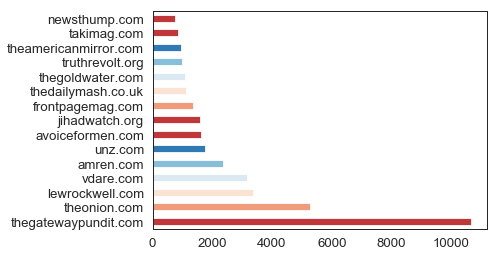

In [61]:
ax = urls.loc[urls['fact'] == 'LOW'].domain.value_counts().head(n=15).plot(kind='barh')

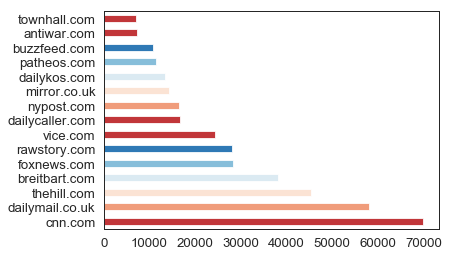

In [62]:
ax = urls.loc[urls['fact'] == 'MIXED'].domain.value_counts().head(n=15).plot(kind='barh')

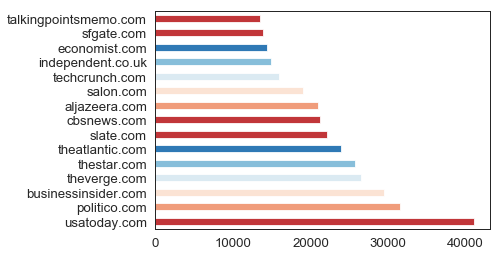

In [63]:
ax = urls.loc[urls['fact'] == 'HIGH'].domain.value_counts().head(n=15).plot(kind='barh')

In [ ]:
urls_master = master.merge(urls, on='filename')

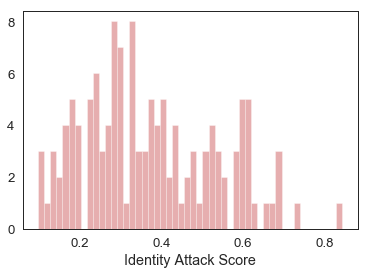

In [79]:
sns.distplot(urls_master.loc[urls_master.domain == 'thegatewaypundit.com']['Identity Attack Score'], kde=False, bins=50)

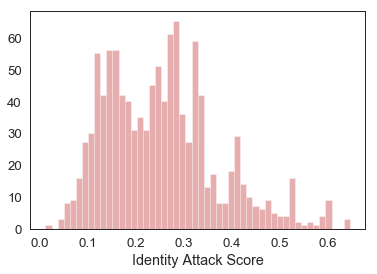

In [81]:
sns.distplot(urls_master.loc[urls_master.domain == 'nytimes.com']['Identity Attack Score'], kde=False, bins=50)

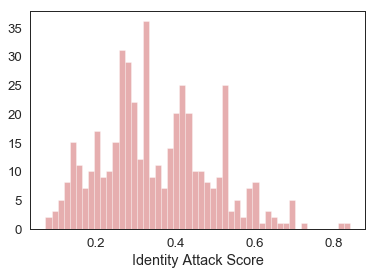

In [82]:
sns.distplot(urls_master.loc[urls_master.domain == 'breitbart.com']['Identity Attack Score'], kde=False, bins=50)